This file trains and compares simple models from scikit-learn.<br>
Given the number of molecules in the dataset, they are likely to perform better than neural networks would.

<p>
The task is to distinguish if a molecule has a pIC50>8 or not. Therefore, we are interested in binary classifiers, like SVM, random forest, and naive bayes methods.

<p>Loss for them is typicaly measured with cross entropy, while their validation is often scored on accuracy, recall and derrived measures (F1), as well as the area under the ROC curve. In the case of a heavily biased dataset, like this one, accuracy can be misleading. What we do care about is correctly identifying as many active molecules as possible (high recall) while also not selecting many inactive ones (high precision). So let us rely on <b>F1</b> (harmonic mean of recal and and precission) which offers a good compromise between the two and <b>AUC</b> (area under the ROC).

# Load the libraries

In [1]:
import pickle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

from CustomMolDataset import CustomMolDataset, dataBlocks

# Load the data

In [2]:
# molecules
with open("molecules_3D.pickle", 'rb') as f:
    ligs = pickle.load(f)
    
# feature filters
with open("X_filt_w3D.pickle", 'rb') as f:
    X_filt_w3D=pickle.load(f)
with open("X_filt_no3D.pickle", 'rb') as f:
    X_filt_no3D=pickle.load(f)


# CustomMolDatasets
DescriptorBlocknames_no3D = ["MACCS", "rdkitFP", "MorganFP2", "MorganFP3",
                             "Descriptors", "EState_FP", "Graph_desc",
                             "MOE", "MQN", "AUTOCORR2D", "PEOE_VSA",
                             "SMR_VSA", "SlogP_VSA"]
DescriptorBlocknames_w3D = DescriptorBlocknames_no3D + [
                             "AUTOCORR3D", "WHIM", "RDF",
                             "USR", "USRCUT", "MORSE"]
flags_no3D = [int(dataBlocks(i).name in DescriptorBlocknames_no3D) for i in range(len(dataBlocks))]
flags_w3D = [int(dataBlocks(i).name in DescriptorBlocknames_w3D) for i in range(len(dataBlocks))]

DB_no3D = CustomMolDataset(ligs,
                  representation_flags = flags_no3D,
                  X_filter=X_filt_no3D,  # feature filter
                  normalize_x = True,   # now we normalize the features
                  use_hdf5_cache = "read-only", # read cache from file
                  name = "EGFR_set_all_features"
                 )
DB_no3D.find_normalization_factors() # will also build a faster in-memory cache
DB_no3D.cache_fp.close() # close the file handle so next dataset can also access it


DB_w3D = CustomMolDataset(ligs,
                  representation_flags = flags_w3D,
                  X_filter=X_filt_w3D, # feature filter
                  normalize_x = True,   # now we normalize the features
                  use_hdf5_cache = "read-only", # read cache from file
                  name = "EGFR_set_all_features"
                 )
DB_w3D.find_normalization_factors()
DB_w3D.cache_fp.close()

In [3]:
# function to convert pIC50 values provided by CustomMolDataset to one-hot arrays identifying classes (active/inactive)
# This is more usefull for NNs
def pIC50ToOneHot(y):
    mask=y>8
    return(np.hstack((np.logical_not(mask), mask)).astype(float))

# similar function to produce class numbers
# this is for simple models in this file
def pIC50ToClassID(y):
    mask=y>8
    return(np.hstack((mask)).astype(int))

# Train/Validation and cross-validation splits
Some models have meta-parameters that need tuning. This should not be done on the validation set, so we will do this tuning on cross-validation splits within the training set.

In [26]:
from sklearn.model_selection import KFold, train_test_split

# settings
split_seed = 123450
test_frac = 0.2
xval_folds = 5

# also keep track of the indeces of the split samples
indices = np.arange(DB_no3D.internal_filtered_cache[0].shape[0])

# split the 2D only features
(
    no3D_train_x,
    no3D_test_x,
    no3D_train_y,
    no3D_test_y,
    train_indeces,
    test_indeces,
) = train_test_split(DB_no3D.internal_filtered_cache[0],
                     pIC50ToClassID(DB_no3D.internal_filtered_cache[1]),
                     indices,
                     test_size=test_frac, random_state=split_seed)

# split the 2D+3D features
# because the seed is the same, indeces are also same
(
    w3D_train_x,
    w3D_test_x,
    w3D_train_y,
    w3D_test_y,
) = train_test_split(DB_w3D.internal_filtered_cache[0],
                     pIC50ToClassID(DB_no3D.internal_filtered_cache[1]),
                     test_size=test_frac, random_state=split_seed)

# cross-validation
kf = KFold(n_splits=xval_folds, shuffle=True, random_state=split_seed+1978727) # shift seed by a prime

In [5]:
print(no3D_train_x.shape, no3D_test_x.shape)

(3708, 6740) (927, 6740)


# Weigh classes examples by the number of samples in them
To help deal with unballanced dataset.

In [6]:
from sklearn.utils import class_weight

no3D_train_w = class_weight.compute_sample_weight("balanced", no3D_train_y)
no3D_test_w = class_weight.compute_sample_weight("balanced", no3D_test_y)

w3D_train_w = class_weight.compute_sample_weight("balanced", w3D_train_y)
w3D_test_w = class_weight.compute_sample_weight("balanced", w3D_test_y)

# Set up a lists of models and their performances

In [7]:
models={}
model_AUCs={}
model_F1s={}
model_ROCs_TPR={}
model_ROCs_FPR={}
model_run_time={}

# Functions that summarize classifier performance

In [8]:
from sklearn import metrics
import time

# evaluate model performance
def evaluate(name, classifier, dataX, dataY, weights=None, draw=False, save=True, verbose=True):
    start = time.time()
    predY = classifier.predict(dataX)
    duration=time.time()-start
    
    propability = classifier.predict_proba(dataX)[:, 1] # of the active class
    
    # ROC (weights don't matter), used on probability to get a smooth curve
    fpr, tpr, thresholds = metrics.roc_curve(
                                    dataY, propability,
                                    sample_weight=weights,
                                    pos_label=1       # actives are in class 1
                                    )
    AUC = metrics.auc(fpr, tpr)
    
    
    # F1 (weights don't matter in 'binary' averaging), used on actual predicted class
    pre, rec, F1, _ = metrics.precision_recall_fscore_support(
                                    dataY, predY,
                                    sample_weight=weights,
                                    pos_label=1,       # actives are in class 1
                                    average='binary'   
                                    )

    # report results
    if(verbose):
        print(f"AUC: {AUC:.3}\tF1: {F1:.3}, prec:{pre:.3}, recal:{rec:.3}")
    
    if(draw):
        plt.axis("square")
        plt.plot([0, 1], [0, 1], "k--", label="chance AUC=0.5")
        plt.plot(fpr,tpr, label=f"{name} AUC={AUC:.3}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC")
        plt.xlim((0,1))
        plt.ylim((0,1))
        plt.legend()
        plt.show()
    
    # write results into performance tracking dicts
    models[name] = classifier
    model_AUCs[name] = AUC
    model_F1s[name] = F1
    model_ROCs_TPR[name] = tpr
    model_ROCs_FPR[name] = fpr
    model_run_time[name] = duration
    
    # save the data to HDD for recovery in case of crash
    if(save):
        with open("simple_models_metrics.pickle", 'wb') as f:
            pickle.dump((models, model_AUCs, model_F1s,
                         model_ROCs_TPR, model_ROCs_FPR,
                         model_run_time),
                        f)

# Train SVMs
While searching for best regularization parameter C.
<p>
When hyper-parameter tuning SVNs, it's best to avoid probability=True, otherwize we will be doing cross validation twice during training. Once from probability=True and once from GridSearchCV. So after finding the optimal hyper-parameters, let's refit the SVNs manually with probability=True.

## Linear SVM classifier

Best parameters: {'C': 0.25}
AUC: 0.856	F1: 0.737, prec:0.868, recal:0.64


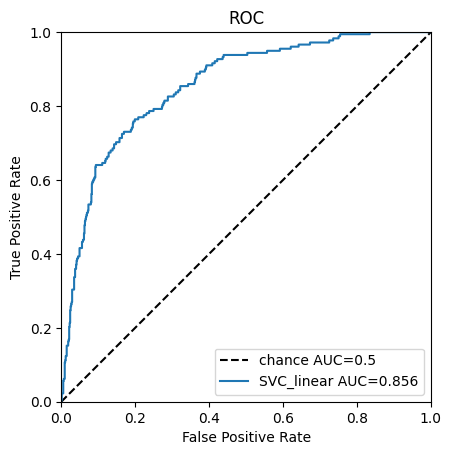

In [223]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# do a hyper-parameter search
param_grid = {'C': [0.025, 0.25, 1.0, 4.0, 16.0]}
base_estimator = SVC(kernel="linear", probability=False,
                     random_state=42, class_weight="balanced")

sh = GridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=False,    # fit best parameters on all data 
                 ).fit(no3D_train_x, no3D_train_y)

print("Best parameters:", sh.best_params_)

# fit final version on all training data with probability estimates
best_estimator=SVC(kernel="linear", probability=True,
                   random_state=42, class_weight="balanced",
                   **sh.best_params_)
best_estimator.fit(no3D_train_x, no3D_train_y)

evaluate("SVC_linear", best_estimator, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

## radial-basis function SVM classifier
Search both C and gamma.
<p>
Let's use HalvingGridSearchCV, using small number of samples for all hyper-parameter combinations, and iteratively incrising the number of samples while retaining the best combinations. This should be faster than training all combinations on all samples. Also manages to produce a higher F1 on the validation (test) set.

Best parameters: {'C': 4.0, 'gamma': 2.967359050445104e-05}
AUC: 0.911	F1: 0.819, prec:0.847, recal:0.792


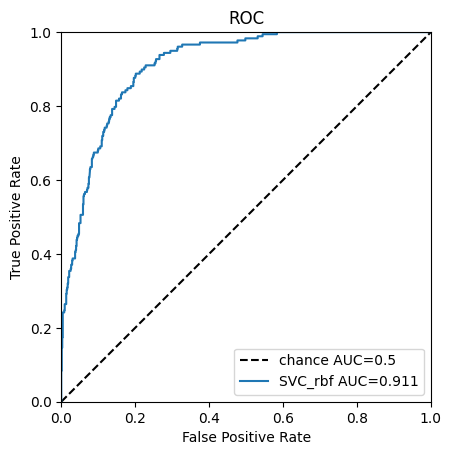

In [217]:
# since HalvingGridSearchCV is experimental, need to explicitly import:
from sklearn.experimental import enable_halving_search_cv
# it's API might change without any deprecation cycle
from sklearn.model_selection import HalvingGridSearchCV


# do a hyper-parameter search
# features already have variance 1, so default gamma = 1/N features here
param_grid = {'C': [0.025, 0.25, 1.0, 4.0, 16.0],
              'gamma': np.array([0.04, 0.2, 1, 5, 25])/no3D_train_x.shape[1]} 
base_estimator = SVC(kernel="rbf", probability=False,
                     random_state=42, class_weight="balanced")

sh = HalvingGridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=False,   # fit best parameters on all data
                  min_resources=200, # at least train on 200 samples
                  factor=2,      # double number of samples each iteration
                 ).fit(no3D_train_x, no3D_train_y)

print("Best parameters:", sh.best_params_)

# fit final version on all training data with probability estimates
best_estimator=SVC(kernel="rbf", probability=True,
                   random_state=42, class_weight="balanced",
                   **sh.best_params_)
best_estimator.fit(no3D_train_x, no3D_train_y)

evaluate("SVC_rbf", best_estimator, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

# Random Forest
It should be faster to do a halving search instead, increasing the number of estimators each iteration

Best parameters: {'max_depth': 17, 'min_samples_split': 10, 'n_estimators': 297}
AUC: 0.912	F1: 0.762, prec:0.885, recal:0.669


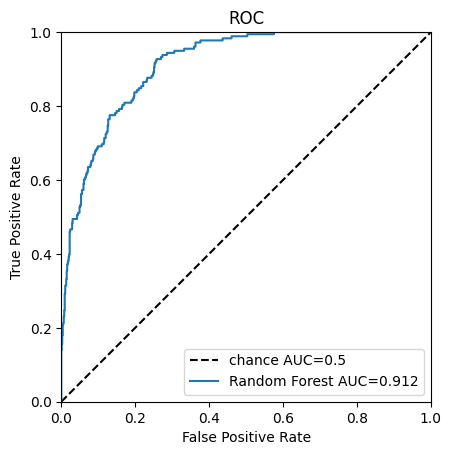

In [164]:
from sklearn.ensemble import RandomForestClassifier

# do a hyper-parameter search
param_grid = {'min_samples_split': [2, 5, 10, 15, 20],
              'max_depth': ([3, 5, 7, 13, 17, None])}
base_estimator = RandomForestClassifier(criterion='entropy',
                                        random_state=42, class_weight="balanced")

sh = HalvingGridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=True,    # fit best parameters on all data 
                  resource='n_estimators', # give each iteration more estimators
                  max_resources=300
                 ).fit(no3D_train_x, no3D_train_y)

print("Best parameters:", sh.best_params_)
evaluate("Random Forest", sh.best_estimator_, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

#  AdaBoost on Descision Trees

AUC: 0.857	F1: 0.609, prec:0.877, recal:0.466


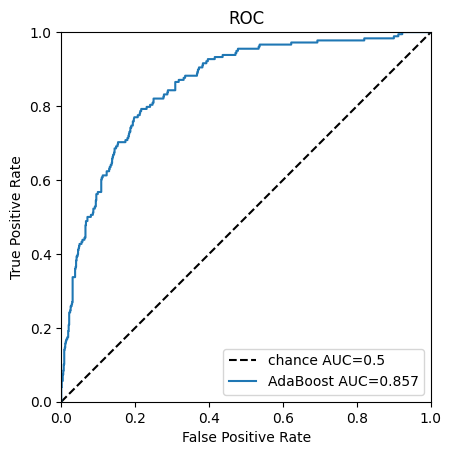

In [178]:
from sklearn.ensemble import AdaBoostClassifier

estimator= AdaBoostClassifier(n_estimators=100, random_state=42)
estimator.fit(no3D_train_x, no3D_train_y)
evaluate("AdaBoost", estimator, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

# Naive Bayes (Gaussian only)
Does not support weighted training as implemented in sklearn.<br> 
No metaparameters to fit. Other implemented types of Naive Bayes only work with categorical data.

AUC: 0.714	F1: 0.702, prec:0.732, recal:0.674


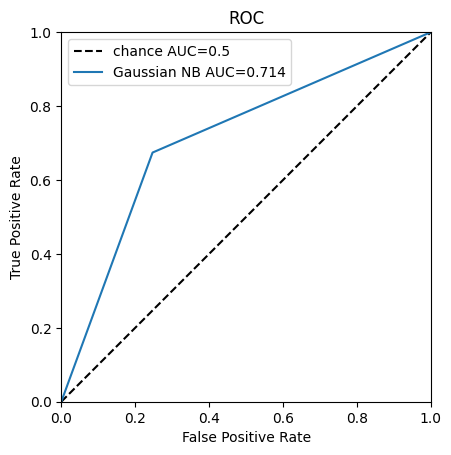

In [174]:
from sklearn.naive_bayes import GaussianNB

estimator = GaussianNB()
estimator.fit(no3D_train_x, no3D_train_y)
evaluate("Gaussian NB", estimator, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

# Compare best models of each type so far

In [141]:
# re-evaluate the models, if needed
for key in tqdm(models.keys()):
    evaluate(key, models[key], no3D_test_x, no3D_test_y, weights=no3D_test_w, draw=False, save=True, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.15s/it]


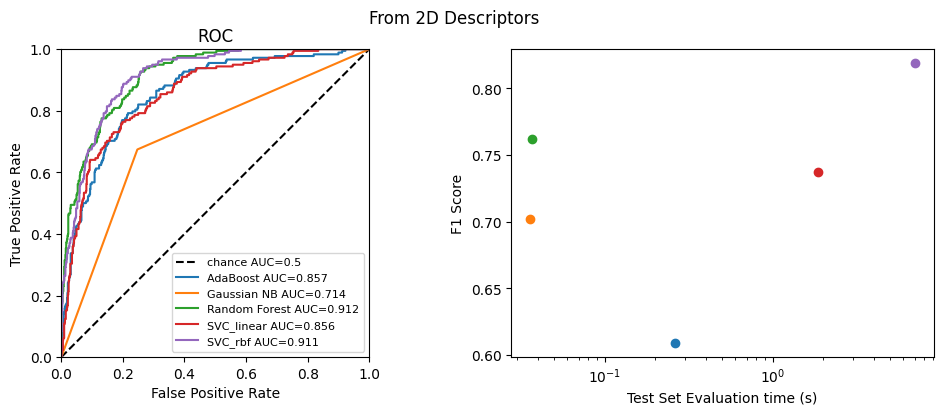

In [224]:
plt.figure(figsize=(12,4))

# ROC
plt.subplot(1,2,1)
plt.axis("square")
plt.plot([0, 1], [0, 1], "k--", label="chance AUC=0.5")
# loop through all saved models
for key in sorted(models.keys()):
    if(not "3D_" in key):
        plt.plot(model_ROCs_FPR[key],
                 model_ROCs_TPR[key],
                 label=f"{key} AUC={model_AUCs[key]:.3}")
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(fontsize=8)

# F1 vs execution time
plt.subplot(1,2,2)
for key in sorted(models.keys()):
    if(not "3D_" in key):
        plt.scatter([model_run_time[key]], [model_F1s[key]], label=key)
plt.xlabel("Test Set Evaluation time (s)")
plt.ylabel("F1 Score")
plt.gca().set_xscale('log')

plt.suptitle("From 2D Descriptors")
plt.show()

### Analysis
So far, a Support Vector Machine with a radial basis function kernel offers the best F1 scores, but at a considerable time cost. <br>
If this model needs to be applied to large datasets with billions of molecules, I would try to reduce the number of features or use the much faster and slightly less accurate RandomForest classifier.

# Test classifier types for 2D+3D Descriptors
Before trying to minimize execution time and overtraining by reducing the feature space, I would like first test if the 3D Descriptors can improve the predictive power.

In [190]:
# linear SVM
param_grid = {'C': [0.025, 0.25, 1.0, 4.0, 16.0]}
base_estimator = SVC(kernel="linear", probability=False,
                     random_state=42, class_weight="balanced")

sh = GridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=False,    # fit best parameters on all data 
                 ).fit(w3D_train_x, w3D_train_y)
print("Best parameters:", sh.best_params_)
# fit final version on all training data with probability estimates
best_estimator=SVC(kernel="linear", probability=True,
                   random_state=42, class_weight="balanced",
                   **sh.best_params_)
best_estimator.fit(w3D_train_x, w3D_train_y)
evaluate("3D_SVC_linear", best_estimator, w3D_test_x, w3D_test_y, draw=False, weights=w3D_test_w)


######################################
# RBF SVM, will switch to HalvingGridSearchCV, as this is slow
param_grid = {'C': [0.025, 0.25, 1.0, 4.0, 16.0],
              'gamma': np.array([0.04, 0.2, 1, 5, 25])/no3D_train_x.shape[1]} 
base_estimator = SVC(kernel="rbf", probability=False,
                     random_state=42, class_weight="balanced")
sh = HalvingGridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=False,   # fit best parameters on all data
                  min_resources=200, # at least train on 200 samples
                  factor=2,      # double number of samples each iteration
                 ).fit(w3D_train_x, w3D_train_y)
print("Best parameters:", sh.best_params_)
# fit final version on all training data with probability estimates
best_estimator=SVC(kernel="rbf", probability=True,
                   random_state=42, class_weight="balanced",
                   **sh.best_params_)
best_estimator.fit(w3D_train_x, w3D_train_y)
evaluate("3D_SVC_rbf", best_estimator, w3D_test_x, w3D_test_y, draw=False, weights=w3D_test_w)


######################################
# Random Forest
param_grid = {'min_samples_split': [2, 5, 10, 15, 20],
              'max_depth': ([3, 5, 7, 13, 17, None])}
base_estimator = RandomForestClassifier(criterion='entropy',
                                        random_state=42, class_weight="balanced")
sh = HalvingGridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=True,    # fit best parameters on all data 
                  resource='n_estimators', # give each iteration more estimators
                  max_resources=300
                 ).fit(w3D_train_x, w3D_train_y)
print("Best parameters:", sh.best_params_)
evaluate("3D_Random Forest", sh.best_estimator_, w3D_test_x, w3D_test_y, draw=False, weights=w3D_test_w)


######################################
# AdaBoost
estimator= AdaBoostClassifier(n_estimators=100, random_state=42)
estimator.fit(w3D_train_x, w3D_train_y)
evaluate("3D_AdaBoost", estimator, w3D_test_x, w3D_test_y, draw=False, weights=w3D_test_w)


######################################
# Naive Bayes
estimator = GaussianNB()
estimator.fit(w3D_train_x, w3D_train_y)
evaluate("3D_Gaussian NB", estimator, w3D_test_x, w3D_test_y, draw=False, weights=w3D_test_w)

Best parameters: {'C': 0.25}
AUC: 0.868	F1: 0.722, prec:0.857, recal:0.624
Best parameters: {'C': 1.0, 'gamma': 0.0001483679525222552}
AUC: 0.917	F1: 0.799, prec:0.858, recal:0.747
Best parameters: {'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 297}
AUC: 0.893	F1: 0.756, prec:0.851, recal:0.68
AUC: 0.85	F1: 0.579, prec:0.854, recal:0.438
AUC: 0.714	F1: 0.702, prec:0.732, recal:0.674


# Comparison Figures
Dotted lines and empty circles are the models using both 2D and 3D descriptors

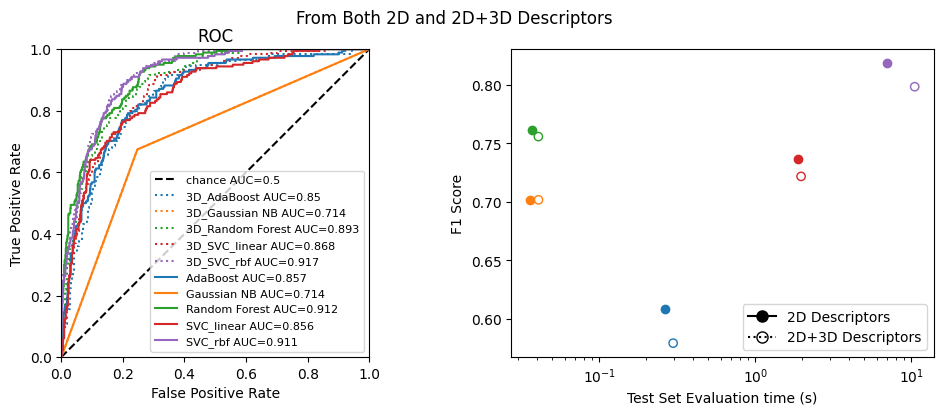

In [225]:
from matplotlib.lines import Line2D

plt.figure(figsize=(12,4))

# ROC
plt.subplot(1,2,1)
plt.axis("square")
plt.plot([0, 1], [0, 1], "k--", label="chance AUC=0.5")
# loop through all saved models
c2D=0
c3D=0
for key in sorted(models.keys()):
    if("3D_" in key):  # dotted lines for 3D
        linestyle="dotted"
        c=f"C{c3D}"
        c3D+=1
    else:
        linestyle="solid"
        c=f"C{c2D}"
        c2D+=1
    plt.plot(model_ROCs_FPR[key],
             model_ROCs_TPR[key],
             linestyle=linestyle,
             color=c,
             label=f"{key} AUC={model_AUCs[key]:.3}")
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(fontsize=8)

# F1 vs execution time
c2D=0
c3D=0
plt.subplot(1,2,2)
for key in sorted(models.keys()):
    if("3D_" in key): # empty circles for 3D
        plt.scatter([model_run_time[key]], [model_F1s[key]],
                    edgecolors=f"C{c3D}",
                    facecolors='none', label=None)
        c3D+=1
    else:
        plt.scatter([model_run_time[key]], [model_F1s[key]],
                    edgecolors=f"C{c2D}",
                    facecolors=f"C{c2D}",
                    label=None)
        c2D+=1
plt.xlabel("Test Set Evaluation time (s)")
plt.ylabel("F1 Score")
plt.gca().set_xscale('log')

# manual legend
handles, labels = plt.gca().get_legend_handles_labels()
m_solid = Line2D([0], [0], label='2D Descriptors', marker='o', markersize=8, 
         markeredgecolor='k', markerfacecolor='k', linestyle='-', color='k')
m_dotted = Line2D([0], [0], label='2D+3D Descriptors', marker='o', markersize=8, 
         markeredgecolor='k', linestyle=':', markerfacecolor=(0, 0, 0, 0.0), color='k')
# add manual symbols to auto legend
handles.extend([m_solid, m_dotted])
plt.legend(handles=handles, loc='lower right')


plt.suptitle("From Both 2D and 2D+3D Descriptors")
plt.show()

### Analysis
Adding 3D descriptors, just makes the models worse. Likely due to more free parameters and overtraining.<br>
Best model remains SVM classifier with Radial Basis Functions.

# PCA dimentionality reduction
Plan is to project the data into a lower dimentional space before training the next iteration of SVM clasifiers. This should increase speed and help with overtraining.
<p>
Projection should be calculated based on the training set and applied to the validation set prior to the evalauation.

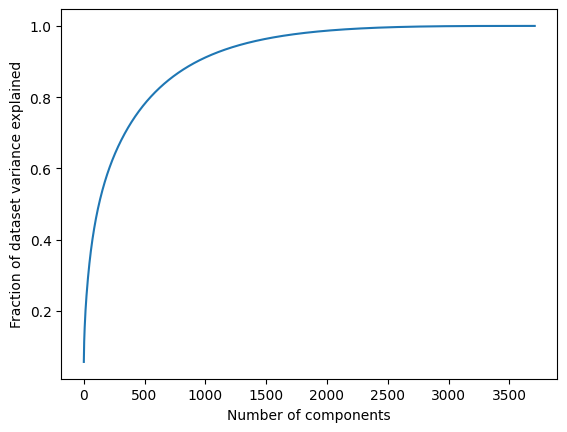

3708 (3708, 6740)


In [240]:
from sklearn.decomposition import PCA

pca = PCA().fit(no3D_train_x)

plt.plot(np.arange(len(pca.explained_variance_ratio_))+1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Fraction of dataset variance explained")
plt.show()

Maximum number of components is min(num_features, num_samples), so 3708 in the training set.<br>
Let's try training SVM in on a transformed dataset and tune the number of components as a hyper-parameter.<br>
This will require a custom class to feed to GridSearchCV and use its built in cross validation.

In [12]:
from sklearn.utils.estimator_checks import check_estimator, NotFittedError
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# custom subclass of Support Vector Machine Classifier that first transforms data into a lower dimentional space with PCA
class SVC_on_PCA_embedded(SVC):
    def __init__(self, n_components=2, kernel="rbf", C=1, gamma='scale',
                 probability=False, random_state=0, class_weight="balanced"):
        super().__init__(kernel=kernel, C=C, gamma=gamma,
                         probability=probability, random_state=random_state, class_weight=class_weight)
        self.n_components = n_components
        
    def fit(self, X, Y):
        # fit PCA
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)
        
        # get lower dimentional embedding
        E = self.pca.transform(X)
        
        # train SVC
        return(super().fit(E,Y))
    
    def predict(self, X):
        E = self.pca.transform(X)
        return(super().predict(E))
        
    def predict_proba(self, X):
        E = self.pca.transform(X)
        return(super().predict_proba(E))
        
# check if class is API compliant
# This fails because of a miscommunication within SVC self-checks, but the class actually works fro what I need
#check_estimator(SVC_on_PCA_embedded()) 

Best parameters: {'C': 2.0, 'gamma': 0.00044510385756676556, 'n_components': 250}
AUC: 0.906	F1: 0.797, prec:0.861, recal:0.742


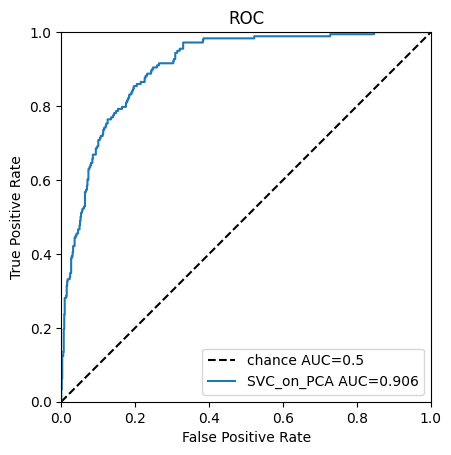

In [284]:
# do a hyper-parameter search
param_grid = {'C': [0.5, 1.0, 2.0],
              'gamma': np.array([0.2, 1, 3, 5, 10])/no3D_train_x.shape[1],
              'n_components': [10,50,100,150,200,250,300,500]} 
base_estimator = SVC_on_PCA_embedded(kernel="rbf", probability=False,
                                     random_state=42, class_weight="balanced")

sh = HalvingGridSearchCV(
                  base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=False,   # fit best parameters on all data
                     # at least train on this many samples to avoid PCA errors
                  min_resources=int(max(param_grid['n_components'])*((xval_folds+2)/xval_folds))+1,
                  factor=2,      # double number of samples each iteration
                 ).fit(no3D_train_x, no3D_train_y)

print("Best parameters:", sh.best_params_)

# fit final version on all training data with probability estimates
best_estimator=SVC_on_PCA_embedded(kernel="rbf", probability=True,
                   random_state=42, class_weight="balanced",
                   **sh.best_params_)
best_estimator.fit(no3D_train_x, no3D_train_y)

evaluate("SVC_on_PCA", best_estimator, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

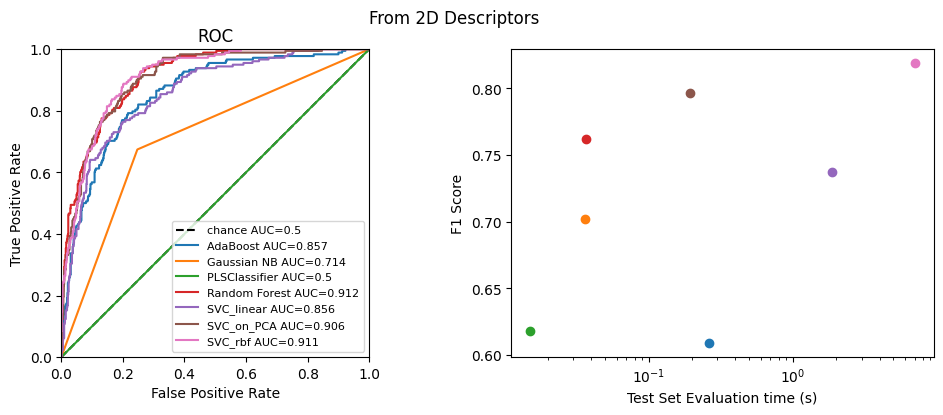

In [66]:
plt.figure(figsize=(12,4))

# ROC
plt.subplot(1,2,1)
plt.axis("square")
plt.plot([0, 1], [0, 1], "k--", label="chance AUC=0.5")
# loop through all saved models
for key in sorted(models.keys()):
    if(not "3D_" in key):
        plt.plot(model_ROCs_FPR[key],
                 model_ROCs_TPR[key],
                 label=f"{key} AUC={model_AUCs[key]:.3}")
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(fontsize=8)

# F1 vs execution time
plt.subplot(1,2,2)
for key in sorted(models.keys()):
    if(not "3D_" in key):
        plt.scatter([model_run_time[key]], [model_F1s[key]], label=key)
plt.xlabel("Test Set Evaluation time (s)")
plt.ylabel("F1 Score")
plt.gca().set_xscale('log')

plt.suptitle("From 2D Descriptors")
plt.show()

### Analysis
<b>PCA embeding</b> does not improve F1 over using all the features, but does improve execution speed as exdpected.<br>
Curiously, the optimal number of components according to cross validation is 250, not the maximum anount tried. So cross validation may disagree with the test set on this, possibly because of differing PCA transformations on the K-fold sets and the full trainig set.

# Load pickled models from previous runs, if any
To avoid re-training models after restarting this notebook, load the previously saved ones

In [74]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import os.path

if(os.path.isfile("simple_models_metrics.pickle")):
    with open("simple_models_metrics.pickle", 'rb') as f:
        (models, model_AUCs, model_F1s,
        model_ROCs_TPR, model_ROCs_FPR,
        model_run_time) = pickle.load(f)

# PLS embedding and regression as a classifier
Similarly to the PCA dimention reduction trick one can also train a PLS regression model, and use its transform function to get a different, typically more compact, lower dimentional embedding. However, this requires one to also have continuous Y-values (pIC50) for the training set, not just class assignments.
<p>
One can also use a regression model as a classifier with a manual descision function, though they tend to be less good at distinguishing samples near the class boundary (pIC50=8). On the other hand, regression models do allow one to select more strongly active compounds without retraining the model.
<p>  
Unfortunately, PLS once again does not support weights for training data, so let's skip unbiasing.

## Find optimal numer of PLS components
As judged by cross-validation MSE.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:55<00:00,  3.99s/it]

Best MSE=0.6673787061422756 at 8 components


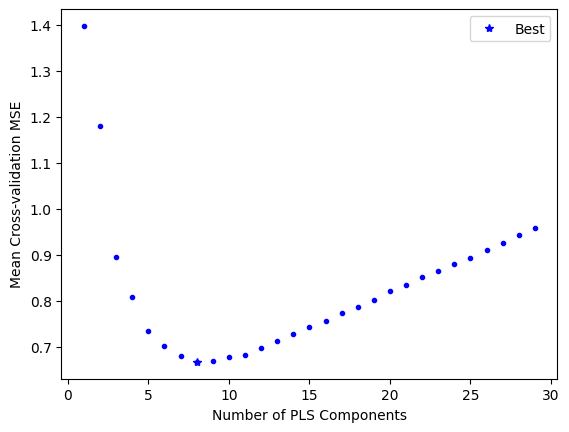

In [65]:
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection
# from sklearn.metrics import mean_squared_error

# set up variables
mse = []
n = 30 # max PLS components to test

# Calculate MSE using cross-validation, adding one component at a time
for i in trange(1, n):
    pls = PLSRegression(n_components=i,
                        scale=False) # don't re-normalize data
    score = -1*model_selection.cross_val_score(pls, no3D_train_x, train_pIC50, cv=kf,
               scoring='neg_mean_squared_error').mean()
    mse.append(score)

# report optimum
best_n_PLS_components = np.argmin(mse)+1
print(f"Best MSE={mse[best_n_PLS_components-1]} at {best_n_PLS_components} components")

# plot result
plt.plot(np.arange(1,n), mse, "b.")
plt.plot([best_n_PLS_components], mse[best_n_PLS_components-1], "b*", label="Best")

plt.xlabel("Number of PLS Components")
plt.ylabel("Mean Cross-validation MSE")
plt.legend()
plt.show()

# Use PLS Regression as a classifier
Decision rule is if PLS predicts pIC50>8, then sample is labeled active.

AUC: 0.5	F1: 0.618, prec:0.896, recal:0.472


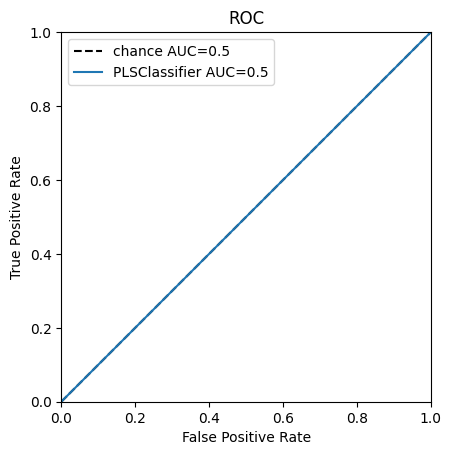

In [69]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_decomposition import PLSRegression

# custom class for using PLS as a classifier with a fixed decision criterion
class PLSClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=best_n_PLS_components):
        self.n_components = n_components
        
    def fit(self, X, Y):
        # fit PLS
        self.pls = PLSRegression(n_components=self.n_components, scale=False)
        self.pls.fit(X, Y)
       
        return(self)
    
    def predict(self, X):
        # predict pIC50
        predicted_pIC50 = self.pls.predict(X)
        # apply the decision criterion
        predicted_class = (predicted_pIC50>8).astype(int)
        return(predicted_class)
    
    def predict_proba(self, X):
        # predict class probabilities (1 if predict says it is that class)
        predicted_class = self.predict(X)
        predicted_probabilities = np.zeros((X.shape[0],2))
        predicted_probabilities[:,predicted_class] = 1
        return(predicted_probabilities)
    
# Train on the training set
pls=PLSClassifier(n_components=best_n_PLS_components)
pls.fit(no3D_train_x, train_pIC50)

# evaluate on validation set
evaluate("PLSClassifier", pls, no3D_test_x, no3D_test_y, draw=True, weights=no3D_test_w)

### Analysis
As expected, using a regression model as a classifier is not effective.

## Let's try SMV classifier in the PLS reduced dimetionality space

In [70]:
# First transform the training and test features into the PLS space
no3D_train_pls_x = pls.pls.transform(no3D_train_x)
no3D_test_pls_x = pls.pls.transform(no3D_test_x)

Best parameters: {'C': 4.0, 'gamma': 0.005}
AUC: 0.882	F1: 0.82, prec:0.843, recal:0.798


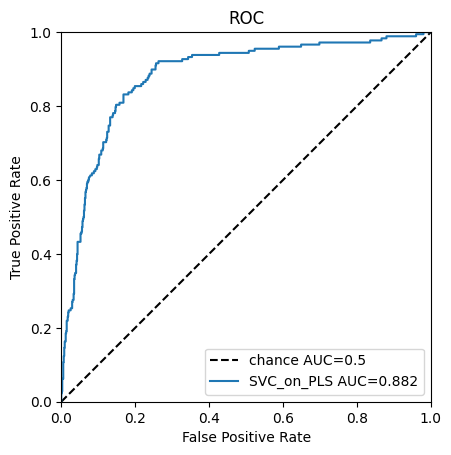

In [71]:
# Train RBF SVM classifier on the transformed features
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


# do a hyper-parameter search
# features already have variance 1, so default gamma = 1/N features here
param_grid = {'C': [0.025, 0.25, 1.0, 4.0, 16.0],
              'gamma': np.array([0.04, 0.2, 1, 5, 25])/no3D_train_pls_x.shape[1]} 
base_estimator = SVC(kernel="rbf", probability=False,
                     random_state=42, class_weight="balanced")

sh = HalvingGridSearchCV(base_estimator, param_grid,
                  scoring='f1',
                  cv=xval_folds, # cross validation folds
                  n_jobs=-1,     # use all processors
                  refit=False,   # fit best parameters on all data
                  min_resources=200, # at least train on 200 samples
                  factor=2,      # double number of samples each iteration
                 ).fit(no3D_train_pls_x, no3D_train_y)

print("Best parameters:", sh.best_params_)

# fit final version on all training data with probability estimates
best_estimator=SVC(kernel="rbf", probability=True,
                   random_state=42, class_weight="balanced",
                   **sh.best_params_)
best_estimator.fit(no3D_train_pls_x, no3D_train_y)

evaluate("SVC_on_PLS", best_estimator, no3D_test_pls_x, no3D_test_y, draw=True, weights=no3D_test_w)

# Replot model comparisons

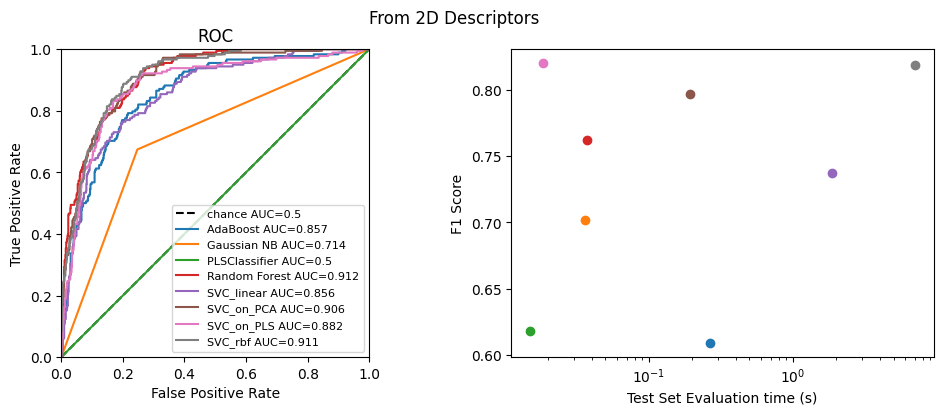

In [73]:
plt.figure(figsize=(12,4))

# ROC
plt.subplot(1,2,1)
plt.axis("square")
plt.plot([0, 1], [0, 1], "k--", label="chance AUC=0.5")
# loop through all saved models
for key in sorted(models.keys()):
    if(not "3D_" in key):
        plt.plot(model_ROCs_FPR[key],
                 model_ROCs_TPR[key],
                 label=f"{key} AUC={model_AUCs[key]:.3}")
    
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(fontsize=8)

# F1 vs execution time
plt.subplot(1,2,2)
for key in sorted(models.keys()):
    if(not "3D_" in key):
        plt.scatter([model_run_time[key]], [model_F1s[key]], label=key)
plt.xlabel("Test Set Evaluation time (s)")
plt.ylabel("F1 Score")
plt.gca().set_xscale('log')

plt.suptitle("From 2D Descriptors")
plt.show()

### Analysis
Using feature dimentionality reduction via PLS before training a radial basis function SVM classifier produces marginally better F1 score than with raw features (0.820 vs 0.819), while drastically increasing the evaluation speed. Admittedly the evaluation speed in the right figure does not include the linear tansformation inside PLS.
<p>
Therefore, I would use this final approach as the most robust one for real applications.

# Save the PLS and the following SVC models for use in the inference pipe line

In [75]:
with open("models_for_inference.pickle", 'wb') as f:
    pickle.dump((pls.pls, models["SVC_on_PLS"]),
                f)